In [1]:
import os
from src.dataPipeline import DataPipeline

os.chdir('..')

In [2]:

columns_to_drop_all = [
'Unnamed: 0.1', 'Unnamed: 0','Municipality','Living space',
'Plot area','Floor space','location','description',
'detailed_description','url','table','detail_responsive#municipality',
'detail_responsive#surface_living','detail_responsive#floor','detail_responsive#available_from',
'Gemeinde','Wohnfläche','Stockwerk','Nutzfläche','Verfügbarkeit','Grundstücksfläche',
'detail_responsive#surface_property','Commune','Surface habitable','Surface du terrain',
'Surface utile','Disponibilité','Étage','Comune','Superficie abitabile','Disponibilità',
'Piano','Superficie del terreno','Superficie utile','Municipality_merged',
'Floor_merged','Living_space_merged','Plot_area_merged','Availability_merged','location_parsed',
'title','price','address','link','details_structured','index',
'Locality','Zip','rooms','Floor_unified','Living_area_unified','space',
'price_s','address_s','Surface living:','Land area:',
'description_detailed','Floor space:','Volume:','plz','Number of toilets:','Gross yield:',
'Minimum floor space:','space_cleaned'''
# Temporary columns
, 'Gross return'
, 'details'
, 'Room height:'
#, 'features'
, 'type'
, 'provider' ,
#'type_unified',
#'Availability',
#'Floor',
#'detail_responsive#surface_usable',
#'Floor_space_merged',
'lat',
'lon',
#'ForestDensityL',
#'ForestDensityM',
#'ForestDensityS',
'Latitude',
'Longitude',
#'NoisePollutionRailwayL',
#'NoisePollutionRailwayM',
#'NoisePollutionRailwayS',
#'NoisePollutionRoadL',
#'NoisePollutionRoadM',
#'NoisePollutionRoadS',
#'PopulationDensityL',
#'PopulationDensityM',
#'PopulationDensityS',
#'RiversAndLakesL',
#'RiversAndLakesM',
#'RiversAndLakesS',
#'WorkplaceDensityL',
#'WorkplaceDensityM',
#'WorkplaceDensityS',
#'distanceToTrainStation',
#'gde_area_agriculture_percentage',
#'gde_area_forest_percentage',
#'gde_area_nonproductive_percentage',
#'gde_area_settlement_percentage',
#'gde_average_house_hold',
#'gde_empty_apartments',
#'gde_foreigners_percentage',
#'gde_new_homes_per_1000',
'gde_politics_bdp',
'gde_politics_cvp',
'gde_politics_evp',
'gde_politics_fdp',
'gde_politics_glp',
'gde_politics_gps',
'gde_politics_pda',
'gde_politics_rights',
'gde_politics_sp',
'gde_politics_svp',
#'gde_pop_per_km2',
#'gde_population',
#'gde_private_apartments',
#'gde_social_help_quota',
#'gde_tax',
'gde_workers_sector1',
'gde_workers_sector2',
'gde_workers_sector3',
#'gde_workers_total',
'plz_parsed',
#'No. of rooms:',
'Number of apartments:',
#'Last refurbishment:',
#'Number of floors:',
#'Year built:',
#'Space extracted',
#'Plot_area_unified',
'Type:',
'Hall height:',
]

In [3]:

from sklearn.impute import SimpleImputer, KNNImputer

imputer = KNNImputer(n_neighbors=5)

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True, columnsToDrop=columns_to_drop_all, imputer=imputer)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:43: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:75: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [2]:
class StandardizeTransform:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return (x - self.mean) / self.std

    def inverse(self, x):
        return x * self.std + self.mean

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error



y = df['price_cleaned']
y_log = np.log(y)

X = df.drop(columns=['price_cleaned'])


# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mapes = []
models = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=10, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    mapes.append(mape)
    models.append(model)

# Durchschnittlicher MAPE
average_mape = np.mean(mapes)
print(f'Durchschnittlicher MAPE über K-Folds: {average_mape:.2f}%')

Durchschnittlicher MAPE über K-Folds: 96.85%


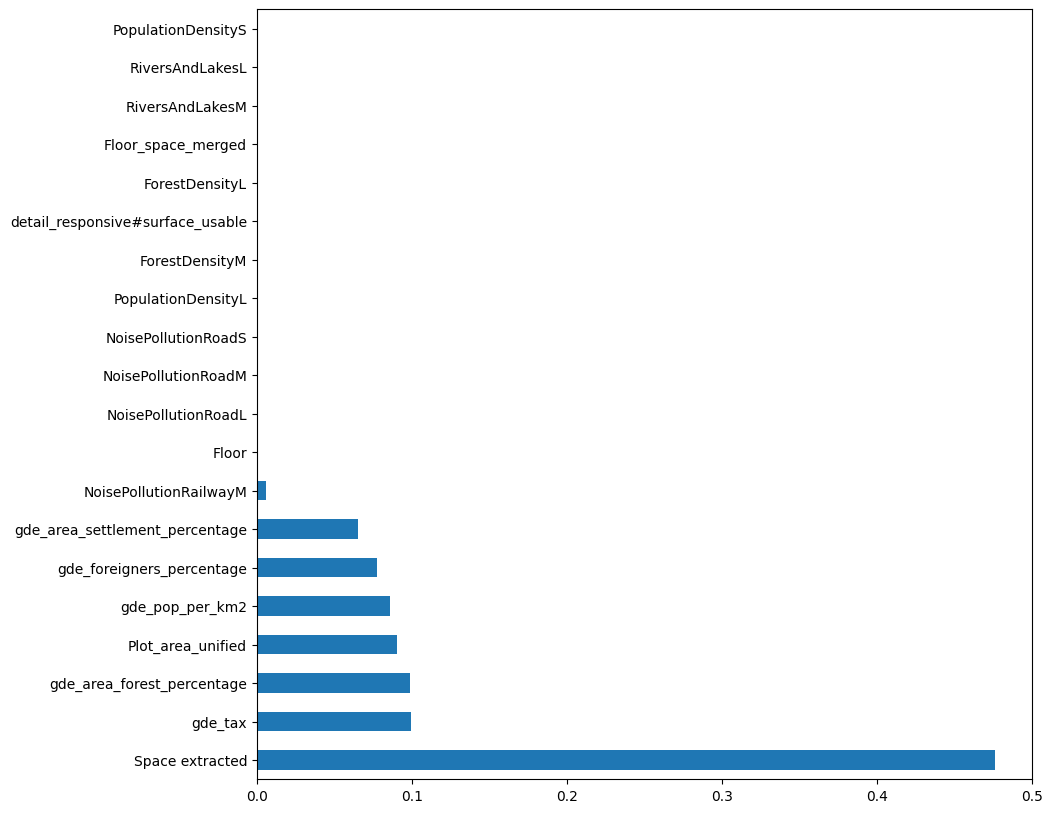

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = np.mean([model.feature_importances_ for model in models], axis=0)
feature_importances = pd.Series(feature_importances, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 10))
feature_importances[:20].plot(kind='barh')
plt.show()

In [5]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mapes = []
models = []


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=1, max_depth=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    print(f'MAPE: {mape:.2f}%')
    mapes.append(mape)
    models.append(model)

# Durchschnittlicher MAPE
average_mape = np.mean(mapes)
print(f'Durchschnittlicher MAPE über K-Folds: {average_mape:.2f}%')

MAPE: 50.32%
MAPE: 27.81%
MAPE: 111.10%
MAPE: 75.46%
MAPE: 40.21%
MAPE: 58.99%
MAPE: 93.51%
MAPE: 87.89%
MAPE: 58.90%
MAPE: 32.08%
Durchschnittlicher MAPE über K-Folds: 63.63%


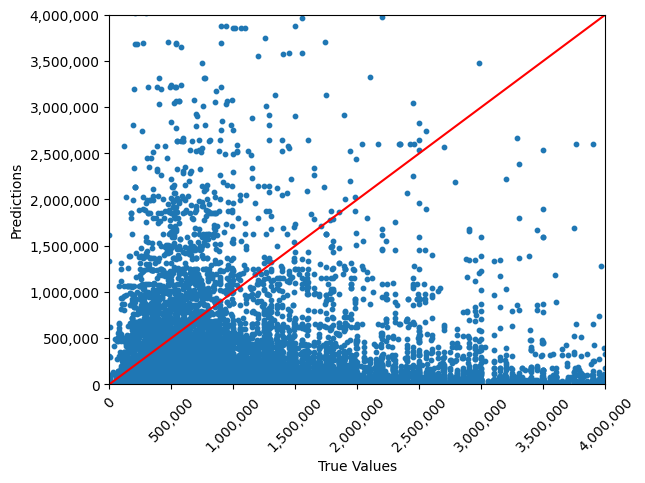

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

largest_num = 4e+6
model = models[2]


df_exclude = df.drop(columns=['price_cleaned'])

df_exclude = dp.scaler.transform(df_exclude)

df_exclude_np = df_exclude
output = model.predict(df_exclude_np)

output = np.exp(output)

plt.scatter(df['price_cleaned'], output, s=10, alpha=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim([0, largest_num])
plt.xlim([0, largest_num])
plt.plot([0, largest_num], [0, largest_num], color='red')

# Set the axes to display whole numbers
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# rotate the x-axis labels
plt.xticks(rotation=45)

plt.show()

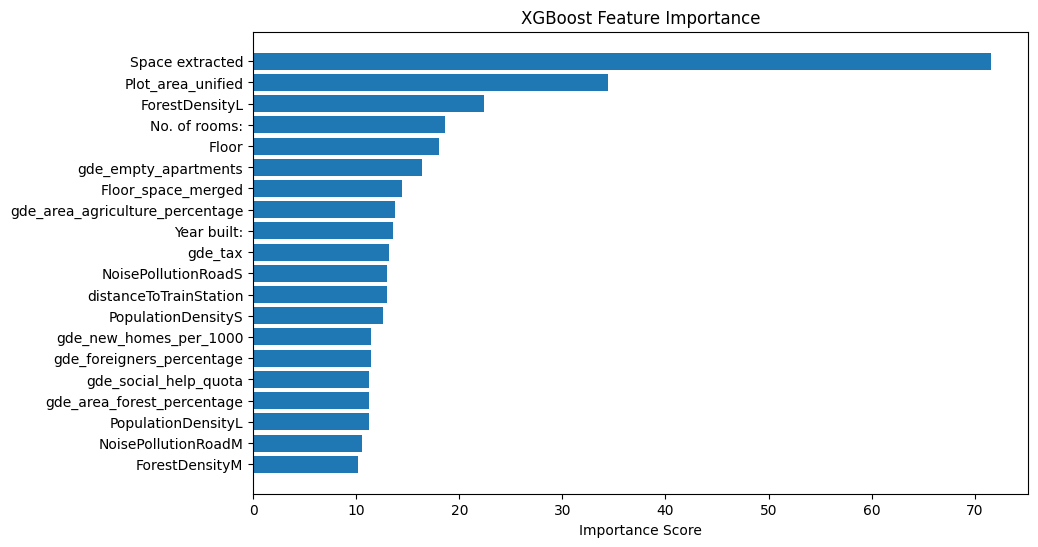

In [7]:
# Get feature importances (default metric is "weight")
importance = model.get_booster().get_score(importance_type='weight')  # Options: 'weight', 'gain', 'cover'
import pandas as pd

for model in models:
    importance = model.get_booster().get_score(importance_type='weight')
    for key in importance.keys():
        if key in importance:
            importance[key] += importance[key]
        else:
            importance[key] = importance[key]
            
importance = {k: v / 10 for k, v in importance.items()}  # Average importance over all models

# Convert feature importance to a DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)
# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])  # Show top 10 features
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


# Model for Kaggle

In [4]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

y = df['price_cleaned']
y_log = np.log(y)

X = df.drop(columns=['price_cleaned'])

model = XGBRegressor(objective='reg:squarederror', n_estimators=10, learning_rate=0.1, max_depth=3)
model.fit(X, y_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [5]:
dp = DataPipeline()
df_test_kaggle = dp.runPipeline(filePath='C:/Users/denis/Downloads/test_data-Kaggle-v0.11.csv/test_data-Kaggle-v0.11.csv', normalizeAndStandardize=True, columnsToDrop=columns_to_drop_all, imputer=imputer)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:43: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:70: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:75: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-

In [6]:
output= model.predict(df_test_kaggle)

In [7]:
output.min(), output.max()

(14.750945, 15.208003)

In [9]:
#output = torch.clamp(output, 6.0, 18.0)
output = np.exp(output)

In [10]:
import pandas as pd

df_test_kaggle_unclean = pd.read_csv('C:/Users/denis/Downloads/test_data-Kaggle-v0.11.csv/test_data-Kaggle-v0.11.csv')


C:\Users\denis\AppData\Local\Temp\ipykernel_30504\2080580583.py:3: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_kaggle_unclean = pd.read_csv('C:/Users/denis/Downloads/test_data-Kaggle-v0.11.csv/test_data-Kaggle-v0.11.csv')


In [11]:
df_test_results = pd.DataFrame(columns=['Id','Expected'])
df_test_results['Id'] = df_test_kaggle_unclean['Unnamed: 0']
df_test_results['Expected'] = output
df_test_results.to_csv('kaggle_results.csv', index=False)

In [13]:
np.exp(15.208)

4024857.2404716997